In [310]:
%load_ext autoreload
%autoreload 2


import pickle
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
from scipy.spatial import Delaunay
import folium as f

from vars import DATASET
from utils import random_nodes, decode_polyline

g_pickle = "./data/01_" + "cambridge" + ".gpickle"
g = nx.read_gpickle(g_pickle)

# node_ids = ['1132394795', '6008681316', '61370808', '4257848370', '1986708490', '64064094', '981460428', '7108530085', '4978546609', '2684107681', '519642929', '5912768531', '61317400', '61318535', '61324412', '61325844', '61170997', '5674432710', '620842047', '7762626866', '4865683882', '2487061247', '61561829', '1037989319', '61364203']

central_square = '61317423'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [311]:
# import pickle
# with open('./data/07_hardcoded_point_names.pkl', 'wb') as f:
#     pickle.dump(node_names, f)

# Use triangulation to create subgraph

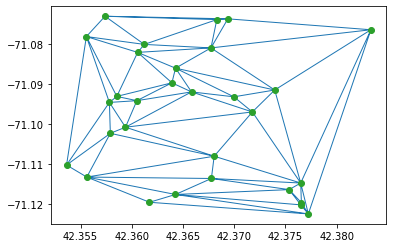

In [312]:
aa = []
for i in range(30):
    aa.append(random_nodes(g)[0])
    
node_ids = {x['id'] for x in aa}

points = []
for node in node_ids:
    node = g.nodes()[node]
    lat, lon = node['lat'], node['lon']
    points.append([lat, lon])

points = np.array(points)
tri = Delaunay(points)

plt.triplot(points[:,0], points[:,1], tri.simplices, linewidth=1)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()


In [313]:
def edges_from_simplex(tri):
    edges = [] 
    points = tri.points
    for simplex in tri.simplices:
        a = points[(simplex[0])].tolist()
        b = points[simplex[1]].tolist()
        c = points[simplex[2]].tolist()
        edges.append([a,b])
        edges.append([b,c])
        edges.append([c,a])
    
    return_edges = []
    for edge in edges:
        if edge not in return_edges and [edge[1], edge[0]] not in return_edges:
            return_edges.append(edge)
    return return_edges

edges = edges_from_simplex(tri)

edges

[[[42.3764902, -71.1147559], [42.3772334, -71.1224862]],
 [[42.3772334, -71.1224862], [42.3833435, -71.0764256]],
 [[42.3833435, -71.0764256], [42.3764902, -71.1147559]],
 [[42.3739535, -71.0914937], [42.3764902, -71.1147559]],
 [[42.3833435, -71.0764256], [42.3739535, -71.0914937]],
 [[42.3739535, -71.0914937], [42.3717709, -71.0969823]],
 [[42.3717709, -71.0969823], [42.3764902, -71.1147559]],
 [[42.357813, -71.0946001], [42.3555661, -71.0781266]],
 [[42.3555661, -71.0781266], [42.3536292, -71.1102614]],
 [[42.3536292, -71.1102614], [42.357813, -71.0946001]],
 [[42.357813, -71.0946001], [42.3585365, -71.0930951]],
 [[42.3585365, -71.0930951], [42.3555661, -71.0781266]],
 [[42.368041, -71.108056], [42.3764902, -71.1147559]],
 [[42.3717709, -71.0969823], [42.368041, -71.108056]],
 [[42.3593827, -71.1007976], [42.368041, -71.108056]],
 [[42.3717709, -71.0969823], [42.3593827, -71.1007976]],
 [[42.3677288, -71.0809673], [42.3642682, -71.0860323]],
 [[42.3642682, -71.0860323], [42.3739535

In [314]:
def node_id_from_latlon(latlon):
    lat,lon = latlon
    for node in g.nodes().data():
        if node[1]['lat'] == lat and node[1]['lon'] == lon:
            return (node[0])

In [315]:
walks = []

for edge1 in edges:
    for edge2 in edges:
        if edge1 == edge2: 
            continue
        elif edge1[0] == edge2[0]:
            walks.append({"walk": [edge1, edge2],
                          "source": edge1[1],
                          "inter": [edge2[0]],
                          "dest": edge2[1]})
        elif edge1[0] == edge2[1]:
            walks.append({"walk": [edge1, edge2],
                          "source": edge1[1],
                          "inter": [edge2[1]],
                          "dest": edge2[0]})
        elif edge1[1] == edge2[0]:
            walks.append({"walk": [edge1, edge2],
                           "source": edge1[0],
                           "inter": edge2[0],
                           "dest": edge2[1]})
        elif edge1[1] == edge2[1]:
            walks.append({"walk": [edge1, edge2],
                          "source": edge1[0],
                          "inter": [edge2[1]],
                          "dest": edge2[0]})

In [316]:
def node_id_from_latlon(latlon):
    lat,lon = latlon
    for node in g.nodes().data():
        if node[1]['lat'] == lat and node[1]['lon'] == lon:
            return (node[0])
        
def dist_by_edge(edge): 
    a,b = edge
    lat_a,lon_a = a
    lat_b,lon_b = b
    a_id = node_id_from_latlon(a)
    b_id = node_id_from_latlon(b)
    try: 
        return nx.shortest_path_length(g, source=a_id, target=b_id, weight='havlen')
    except:
        return None


In [317]:
edges_to_eliminate = []

# The lower this number (between 0 and 1), the more lines eliminated
ELIMINATION_CUTOFF = .8


count = 0

for walk in walks:
    count+=1
    if count % 13 == 0: print( str(count) + " / " + str(len(walks)))
    
    BAD_DATA = False
    straight_distance = dist_by_edge((walk.get('source'), walk.get('dest')))
    if straight_distance is None: 
        BAD_DATA = True
        continue
    roundabout_distance = 0
    for edge in walk.get('walk'):  
        edge_dist = dist_by_edge(edge)
        if edge_dist is None: 
            BAD_DATA = True
            continue
        roundabout_distance += dist_by_edge(edge)
    if BAD_DATA: continue
    if (roundabout_distance * ELIMINATION_CUTOFF < straight_distance):
        edges_to_eliminate.append((node_id_from_latlon(walk.get('source')), node_id_from_latlon(walk.get('dest'))))

13 / 708
26 / 708
39 / 708
52 / 708
65 / 708
78 / 708
91 / 708
104 / 708
117 / 708
130 / 708
143 / 708
156 / 708
169 / 708
182 / 708
195 / 708
208 / 708
221 / 708
234 / 708
247 / 708
260 / 708
273 / 708
286 / 708
299 / 708
312 / 708
325 / 708
338 / 708
351 / 708
364 / 708
377 / 708
390 / 708
403 / 708
416 / 708
429 / 708
442 / 708
455 / 708
468 / 708
481 / 708
494 / 708
507 / 708
520 / 708
533 / 708
546 / 708
559 / 708
572 / 708
585 / 708
598 / 708
611 / 708
624 / 708
637 / 708
650 / 708
663 / 708
676 / 708
689 / 708
702 / 708


In [318]:
final_edges = []

for edge in edges:
    is_eliminated = False
    
    source, dest = edge
    source_id = node_id_from_latlon(source)
    dest_id = node_id_from_latlon(dest)
    for edge_to_elim in edges_to_eliminate:
        if (source_id, dest_id) == edge_to_elim:
            is_eliminated = True
            continue
    if not is_eliminated:
        final_edges.append(edge)
        
print ((str (len(edges) - len(final_edges))) + " lines removed out of " + str(len(edges)) + ". Too few? Too many? Change ELIMINATION_CUTOFF.")

25 lines removed out of 79. Too few? Too many? Change ELIMINATION_CUTOFF.


# Map of subgraph. If you don't like what you see, change ELIMINATION_CUTOFF

In [319]:
def shortest_path_by_edge(edge): 
    a,b = edge
    lat_a,lon_a = a
    lat_b,lon_b = b
    a_id = node_id_from_latlon(a)
    b_id = node_id_from_latlon(b)
    try: 
        return nx.shortest_path(g, source=a_id, target=b_id, weight='havlen')
    except:
        return None


m = f.Map(location = [42.3611108,-71.119977], zoom_start=14)
for final_edge in final_edges:
    short_path_edges = shortest_path_by_edge(final_edge)
    if short_path_edges is None: continue
    
    line_locations = [[g.nodes()[n_id]['lat'], g.nodes()[n_id]['lon']] for n_id in short_path_edges]
    m.add_child(f.PolyLine(locations=line_locations, line_opacity=1, color="green"))

display_nums = {}
num = 50
for node_id in node_ids:
    num += 1
    display_nums[node_id] = num

for node_data in g.nodes().data():
    node_id = node_data[1]["id"]
    lon,lat = node_data[1]['lon'], node_data[1]['lat'] 
    
    if node_id in node_ids:
        size = 25
        display_num = 4
#         m.add_child(f.CircleMarker(location=[lat,lon], color="blue", radius=2, tooltip=node_id))
        f.Marker(location=[lat,lon],
                  # Set icon to DivIcon to with conditional style formatting to reference the random temp value.
                  icon=f.DivIcon(html=f"""<div style="border:1px solid green; text-align: center; vertical-align: middle; line-height: {size}px; background-color: white; width: {size}px; height: {size}px; border-radius: {size}px; font-family: sans-serif; color: green;">{display_nums[node_id]}</div>""")
                 ).add_to(m)
m

# Export Final Edges

In [320]:
# import pickle
# with open('./data/07' + DATASET + '_no_central_square_final_edges.pkl', 'wb') as f:
#     pickle.dump(final_edges, f)



In [321]:
final_edges

[[[42.3764902, -71.1147559], [42.3772334, -71.1224862]],
 [[42.3772334, -71.1224862], [42.3833435, -71.0764256]],
 [[42.3833435, -71.0764256], [42.3764902, -71.1147559]],
 [[42.3739535, -71.0914937], [42.3764902, -71.1147559]],
 [[42.3833435, -71.0764256], [42.3739535, -71.0914937]],
 [[42.3739535, -71.0914937], [42.3717709, -71.0969823]],
 [[42.3717709, -71.0969823], [42.3764902, -71.1147559]],
 [[42.3555661, -71.0781266], [42.3536292, -71.1102614]],
 [[42.3536292, -71.1102614], [42.357813, -71.0946001]],
 [[42.357813, -71.0946001], [42.3585365, -71.0930951]],
 [[42.368041, -71.108056], [42.3764902, -71.1147559]],
 [[42.3717709, -71.0969823], [42.368041, -71.108056]],
 [[42.3593827, -71.1007976], [42.368041, -71.108056]],
 [[42.3717709, -71.0969823], [42.3593827, -71.1007976]],
 [[42.3677288, -71.0809673], [42.3642682, -71.0860323]],
 [[42.3739535, -71.0914937], [42.3677288, -71.0809673]],
 [[42.3693776, -71.0736951], [42.3677288, -71.0809673]],
 [[42.3677288, -71.0809673], [42.383343

In [322]:
edges

[[[42.3764902, -71.1147559], [42.3772334, -71.1224862]],
 [[42.3772334, -71.1224862], [42.3833435, -71.0764256]],
 [[42.3833435, -71.0764256], [42.3764902, -71.1147559]],
 [[42.3739535, -71.0914937], [42.3764902, -71.1147559]],
 [[42.3833435, -71.0764256], [42.3739535, -71.0914937]],
 [[42.3739535, -71.0914937], [42.3717709, -71.0969823]],
 [[42.3717709, -71.0969823], [42.3764902, -71.1147559]],
 [[42.357813, -71.0946001], [42.3555661, -71.0781266]],
 [[42.3555661, -71.0781266], [42.3536292, -71.1102614]],
 [[42.3536292, -71.1102614], [42.357813, -71.0946001]],
 [[42.357813, -71.0946001], [42.3585365, -71.0930951]],
 [[42.3585365, -71.0930951], [42.3555661, -71.0781266]],
 [[42.368041, -71.108056], [42.3764902, -71.1147559]],
 [[42.3717709, -71.0969823], [42.368041, -71.108056]],
 [[42.3593827, -71.1007976], [42.368041, -71.108056]],
 [[42.3717709, -71.0969823], [42.3593827, -71.1007976]],
 [[42.3677288, -71.0809673], [42.3642682, -71.0860323]],
 [[42.3642682, -71.0860323], [42.3739535

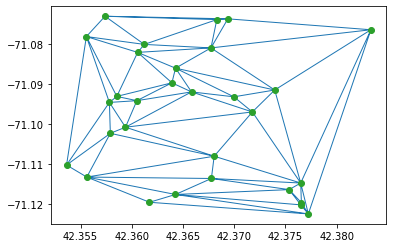

In [323]:
plt.show()
count = len(final_edges)


points = []
for node in node_ids:
    node = g.nodes()[node]
    lat, lon = node['lat'], node['lon']
    points.append([lat, lon])

points = np.array(points)
tri = Delaunay(points)


plt.triplot(points[:,0], points[:,1], tri.simplices, linewidth=1)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()


In [324]:
removed_edges = [edge for edge in edges if edge not in final_edges ]


76
79
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55


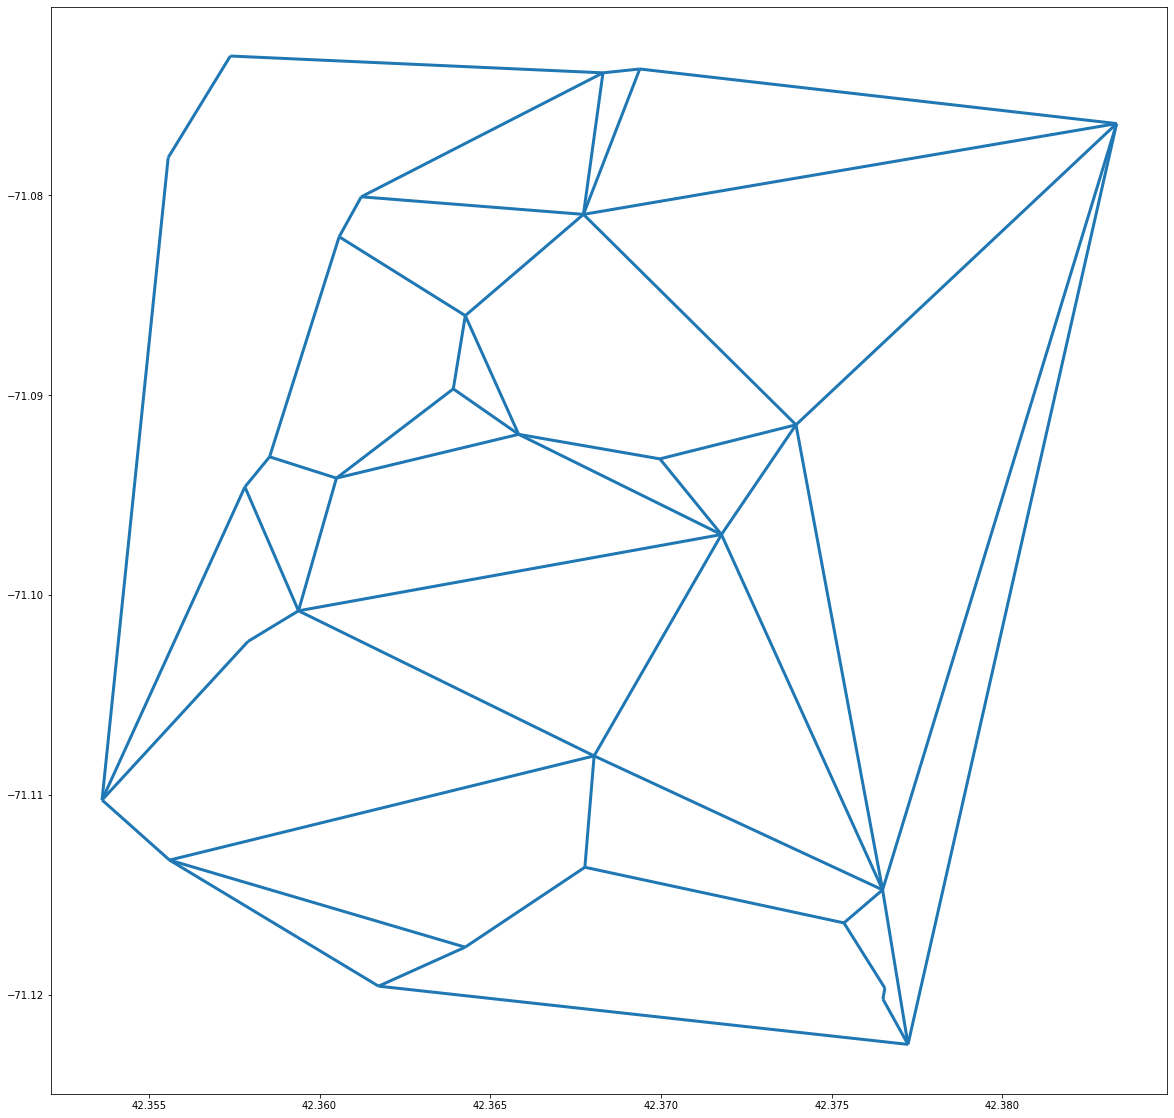

In [325]:
import numpy as np
import pylab as pl
from matplotlib import collections  as mc

def plot(num, edges, removed_edges, ax):
    count = num
    edges_to_show = [edge for edge in edges if edge not in removed_edges[:count]]
    print(len(edges_to_show))
    lc = mc.LineCollection(edges_to_show, linewidths=3)
    ax.add_collection(lc)
    ax.autoscale()
    ax.plot()
    
lc = mc.LineCollection(edges_to_show, linewidth=5)
fig, ax = pl.subplots(figsize=(20,20))
ax.add_collection(lc)
plt.title("Pruning Delaunay")

ax.autoscale()


plot(3, edges, removed_edges, ax)

def animate(num, edges, removed_edges, ax):
    ax.clear()
    plot(num, edges, removed_edges, ax)


line_ani = animation.FuncAnimation(fig, animate, 25, fargs=(edges, removed_edges, ax), interval=300, 
                                   blit=False)
line_ani.save('prune_delaunay' + (str(random.randint(0,100000))) +'.mp4')

